# Subplot for the action potential in an epicardial cardiomyocyte
The figure should include a typical action potential from ten Tusscher model

Source: https://models.physiomeproject.org/e/80c/tentusscher_noble_noble_panfilov_2004_epi.cellml/cellml_math

Reference: https://github.com/SciML/CellMLToolkit.jl

In [20]:
using Pkg
Pkg.activate("../")
using DynamicalSystems
using DifferentialEquations
using CairoMakie

  Activating project at `~/git/projects/perspective_heart_and_brain`


In [21]:
Dt=1e-3

0.001

## Import code from CellML

In [22]:
using CellMLToolkit
ten_tusscher = CellModel("../src/tentusscher_noble_noble_panfilov_2004_epi.cellml")
p = list_params(ten_tusscher)
show(IOContext(stdout, :limit=>false),  MIME"text/plain"(), p)

75-element Vector{Any}:
                        sodium_dynamics₊Na_o => 140.0
                           sodium_dynamics₊F => 96.485
                          sodium_dynamics₊Cm => 185.0
                         sodium_dynamics₊V_c => 16404.0
                 potassium_pump_current₊g_pK => 0.0146
                   reversal_potentials₊P_kna => 0.03
                     reversal_potentials₊K_o => 5.4
                    reversal_potentials₊Na_o => 140.0
                    reversal_potentials₊Ca_o => 2.0
                       reversal_potentials₊R => 8.314
                       reversal_potentials₊F => 96.485
                       reversal_potentials₊T => 310.0
                  calcium_pump_current₊g_pCa => 0.825
                  calcium_pump_current₊K_pCa => 0.0005
                      potassium_dynamics₊K_o => 5.4
                        potassium_dynamics₊F => 96.485
                       potassium_dynamics₊Cm => 185.0
                      potassium_dynamics₊V_c => 16404.0
  

In [23]:
# system equations
sys = ten_tusscher.sys
println(typeof(sys))
display(sys)

Model ##cellml#449 with 17 equations
States (17):
  sodium_dynamics₊Na_i(time) [defaults to 11.6]
  fast_sodium_current_h_gate₊h(time) [defaults to 0.75]
  transient_outward_current_s_gate₊s(time) [defaults to 1.0]
  potassium_dynamics₊K_i(time) [defaults to 138.3]
⋮
Parameters (75):
  sodium_dynamics₊Na_o [defaults to 140.0]
  sodium_dynamics₊F [defaults to 96.485]
  sodium_dynamics₊Cm [defaults to 185.0]
  sodium_dynamics₊V_c [defaults to 16404.0]
⋮
Incidence matrix:17×34 SparseArrays.SparseMatrixCSC{Symbolics.Num, Int64} with 84 stored entries:
⎡⡙⣄⢀⣀⢁⢹⠀⠈⠈⠢⡀⠀⠀⠀⠀⠀⠀⎤
⎢⠀⠀⠑⢄⠀⢸⠀⠀⠀⠀⠈⠢⡀⠀⠀⠀⠀⎥
⎢⣀⣀⣀⣀⣑⣼⣀⢀⠀⠀⠀⠀⠈⠢⡀⠀⠀⎥
⎢⡀⠀⡀⠀⠀⢸⣑⣴⡀⠀⠀⠀⠀⠀⠈⠢⡀⎥
⎣⠀⠀⠁⠀⠀⠀⠀⠉⠁⠀⠀⠀⠀⠀⠀⠀⠈⎦

ModelingToolkit.ODESystem


In [24]:
params = list_params(ten_tusscher)

75-element Vector{Any}:
        sodium_dynamics₊Na_o => 140.0
           sodium_dynamics₊F => 96.485
          sodium_dynamics₊Cm => 185.0
         sodium_dynamics₊V_c => 16404.0
 potassium_pump_current₊g_pK => 0.0146
   reversal_potentials₊P_kna => 0.03
     reversal_potentials₊K_o => 5.4
    reversal_potentials₊Na_o => 140.0
    reversal_potentials₊Ca_o => 2.0
       reversal_potentials₊R => 8.314
                             ⋮
    calcium_dynamics₊Vmax_up => 0.000425
      calcium_dynamics₊Buf_c => 0.15
    calcium_dynamics₊K_buf_c => 0.001
     calcium_dynamics₊Buf_sr => 10.0
   calcium_dynamics₊K_buf_sr => 0.3
       calcium_dynamics₊V_sr => 1094.0
        calcium_dynamics₊V_c => 16404.0
          calcium_dynamics₊F => 96.485
         calcium_dynamics₊Cm => 185.0

In [25]:
# show parameters connected to stimulus
for p in params
    name = string(p[1].name)
    if occursin("stim", name)
        println(p)
    end
end

membrane₊stim_start => 10.0
membrane₊stim_period => 1000.0
membrane₊stim_duration => 1.0
membrane₊stim_amplitude => -52.0


In [52]:
# Removed first stimulus for better visibility of the action potential but keep the structure for future usability of the model.
# first stimulus is a short pulse from 1-2ms with membrane current of -20mV (not the opposite sign convention) until 10ms.
amp_1 = 0.0 # -20.0
update_list!(params, :membrane₊stim_start, 1.0)
update_list!(params, :membrane₊stim_duration, 1.0)
update_list!(params, :membrane₊stim_amplitude, amp_1) # -20.0
update_list!(params, :membrane₊stim_period, 20.0)
# now integrate the system from 0 to 10 using DifferentialEquations
u0 = last.(list_states(ten_tusscher))
tspan = (0.0, 20.0)
prob = ODEProblem(ten_tusscher.sys, u0, tspan, last.(params))
sol = solve(prob, dtmax=1.0, saveat=0.01)
# append I and V
t = sol.t
V = map(x -> x[12], sol.u)
I = zeros(length(t))
I[ 1 .< t .< 2 ] .= amp_1
print(length(t))
# second stimulus is a short pulse from 11-12 with membrane current of -40mV (not the opposite sign convention) until 400ms
update_list!(params, :membrane₊stim_start, 21.0)
update_list!(params, :membrane₊stim_duration, 1.0)
update_list!(params, :membrane₊stim_amplitude, -30.0)
update_list!(params, :membrane₊stim_period, 400.0)
# now integrate the system from 10 to 400 using DifferentialEquations
u0 = sol.u[end]
tspan = (20.0, 400.0)
prob = ODEProblem(ten_tusscher.sys, u0, tspan, last.(params))
sol = solve(prob, dtmax=1.0, saveat=0.01)
# append I and V
t = vcat(t, sol.t)
V = vcat(V, map(x -> x[12], sol.u))
I = vcat(I, zeros(length(sol.t)))
I[ 21 .< t .< 22 ] .= -30;

2001

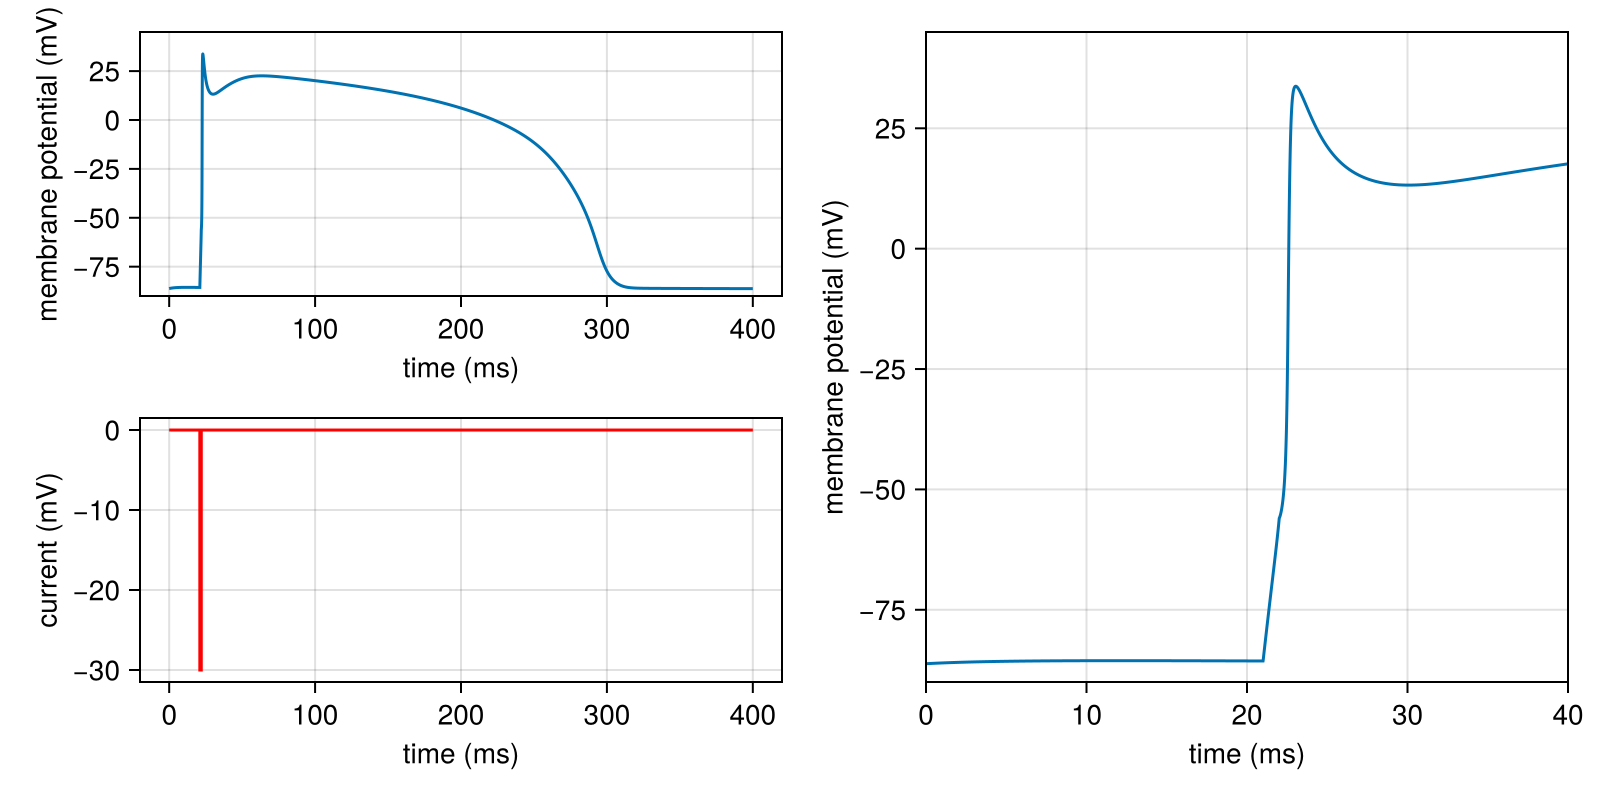

In [66]:
# plot with Makie of time series of membrane potential
fig = Figure(size = (800, 400))
ax = Axis(fig[1, 1]; xlabel = "time (ms)", ylabel = "membrane potential (mV)")
#I_t = [I_stim(t_) for t_ in t]
lines!(ax, t, V)
ylims!(ax, -90, 45)
# current
ax = Axis(fig[2, 1]; xlabel = "time (ms)", ylabel = "current (mV)")
lines!(ax, t, I, color = :red)
# zoom in to the first 50 ms on the right
ax = Axis(fig[:, 2]; xlabel = "time (ms)", ylabel = "membrane potential (mV)")
lines!(ax, t, V)
xlims!(ax, 0, 40)
ylims!(ax, -90, 45)
# plot the resting potential of cardiomyocites
#hlines!(ax, -87.3, color = :black, linestyle = :dash)
fig

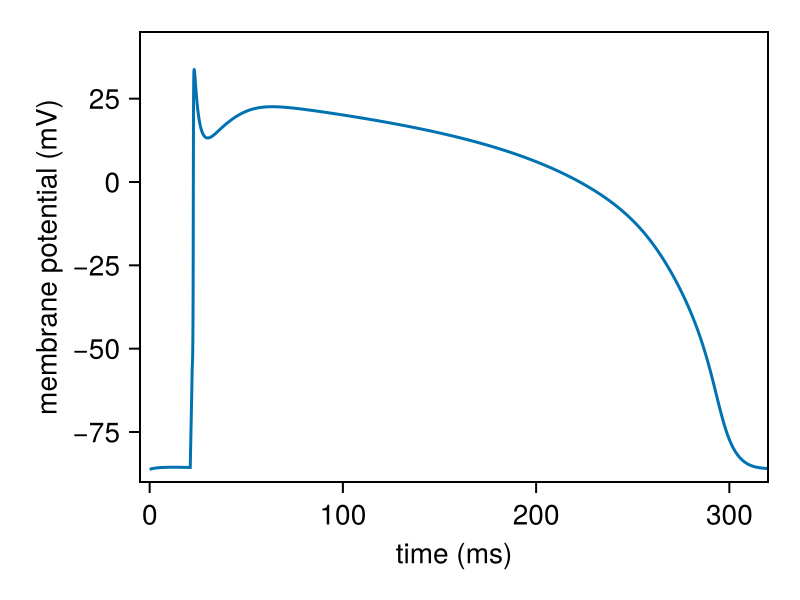

In [67]:
fig = Figure(size = (400, 300))
ax = Axis(fig[1, 1]; xlabel = "time (ms)", ylabel = "membrane potential (mV)", xgridvisible = false, ygridvisible = false)
# hide the decorations
# hidexdecorations!(ax; label = true, ticklabels = true, ticks = true, grid = true,
#     minorgrid = true, minorticks = true)
# hideydecorations!(ax; label = true, ticklabels = true, ticks = true, grid = true,
#     minorgrid = true, minorticks = true)
# hidespines!(ax)
# plot non-zero stimulus as gray area in the plot
mask_stim = I.<0
stimulus_t = t[mask_stim]
stimulus_s = I[mask_stim]
stimulus_s = (stimulus_s) ./ maximum(stimulus_s)
#vlines!(ax, stimulus_t, ymin=1.0, ymax=1.0 .- 0.05*stimulus_s, color = :gray)
# fill between the stimulus and the membrane potential
#band!(stimulus_t, -100 .* ones(length(stimulus_t)), 50 .* ones(length(stimulus_t)), color = (:gray, 0.8))
# set range
xlims!(ax, -5, 320)
ylims!(ax, -90, 45)
# plot the resting potential of cardiomyocites
#hlines!(ax, -87.3, color = :black, linestyle = :dash)
# plot membrane potential
lines!(ax, t, V)
# save as pdf
save("../figures/tentusscher.pdf", fig)

fig